In [2]:
# ======================
# Install dependencies (only once)
# ======================
!pip install kaggle opendatasets natsort matplotlib opencv-python tensorflow pillow scikit-learn

# ======================
# Step 1: Imports
# ======================
import os
import xml.etree.ElementTree as ET
from natsort import natsorted
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
from io import BytesIO
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

import os
import xml.etree.ElementTree as ET
from natsort import natsorted
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# ======================
# Step 2: Download Kaggle dataset
# ======================
def download_kaggle_dataset(kaggle_url, target_dir='./Data'):
    print(f"Downloading from Kaggle: {kaggle_url}")
    od.download(kaggle_url, data_dir=target_dir)
    print(f"Data downloaded to {target_dir}")
    base_dir = os.path.join(target_dir, os.listdir(target_dir)[0])
    return base_dir


In [4]:
# ----------------------
# Step 3: Parse XML and build DataFrame using second code's approach
# ----------------------
def parse_tirads(path):
    from natsort import natsorted
    import xml.etree.ElementTree as ET

    files = natsorted(os.listdir(path))
    xml_files = [f for f in files if f.lower().endswith('.xml')]
    img_files = [f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))]

    records = []
    for xml in xml_files:
        tree = ET.parse(os.path.join(path, xml))
        elems = tree.findall("./tirads")
        if elems and elems[-1].text:
            tirads_val = elems[-1].text.strip().lower()
            base = xml[:-4]
            for img in img_files:
                if img.startswith(base + '_'):
                    records.append([img, tirads_val])

    df = pd.DataFrame(records, columns=['JPG','TIRADS'])
    return df

# ----------------------
# Convert TIRADS to categorical one-hot
# ----------------------
def tirads_to_onehot(df):
    mapping = {'2':0,'3':1,'4a':2,'4b':3,'4c':4,'5':5}
    y_series = df['TIRADS'].astype(str).str.lower().map(mapping)
    valid_mask = y_series.notna()
    y_int = y_series[valid_mask].astype(int).to_numpy()
    df = df[valid_mask]
    y = tf.keras.utils.to_categorical(y_int, num_classes=6).astype(np.float32)
    return df, y


In [5]:
# ======================
# Step 3: Parse XML + Build DataFrame
# ======================
def to_dataframe(path):
    files = natsorted(os.listdir(path))
    xml_files = [f for f in files if f.lower().endswith('.xml')]
    img_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    records = []
    for xml in xml_files:
        xml_path = os.path.join(path, xml)
        tree = ET.parse(xml_path)
        elems = tree.findall(".//tirads")
        if elems and elems[-1].text:
            tirads_val = elems[-1].text.strip()
            base = xml[:-4]
            for img in img_files:
                if img.startswith(base + '_'):
                    records.append([img, tirads_val])

    df = pd.DataFrame(records, columns=['Jpeg_Name', 'Tirads'])
    print(f"Constructed DataFrame with {len(df)} entries")
    return df


In [21]:
# ======================
# Step 4: Crop & Resize Helpers
# ======================
def crop_channel_or_full(img, x, y, w, h):
    return img[y:y+h, x:x+w]

def crop_resize(img_path, resize_shape):
    img = plt.imread(img_path)
    img = np.asarray(img)
    if img.ndim == 3:
        img = img[..., 0]  # grayscale

    thresh = (img > 0).astype(np.uint8) * 255
    kernel = np.ones((5, 5), dtype=np.uint8)
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
    eroded = cv2.erode(opened, kernel, iterations=5)

    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cv2.resize(img, resize_shape, interpolation=cv2.INTER_LANCZOS4)

    cnt = contours[np.argmax([cv2.contourArea(c) for c in contours])]
    x, y, w, h = cv2.boundingRect(cnt)
    roi = crop_channel_or_full(img, x, y, w, h)
    return cv2.resize(roi, resize_shape, interpolation=cv2.INTER_LANCZOS4)

# ======================
# Step 5: Build Image Matrix
# ======================
def to_imgmatrix(resize_shape, path, df):
    images = []
    for fname in df['Jpeg_Name']:
        img = crop_resize(os.path.join(path, fname), resize_shape)
        images.append(img[..., np.newaxis])
    images = np.stack(images, axis=0).astype(np.float32)
    print(f"Built image matrix of shape {images.shape}")
    return images

# ======================
# Step 6: Full Data Prep Pipeline
# ======================
def prepare_data(path, resize_shape=(256, 256)):
    df = to_dataframe(path)
    images = to_imgmatrix(resize_shape, path, df)
    return df, images

df, imgs = prepare_data(data_dir, (256, 256))

# Convert grayscale → RGB (to match ImageNet pretrained weights)
imgs = np.repeat(imgs, 3, axis=-1)   # now shape is (N,256,256,3)

# Labels
y_int, mask = to_categoricalmatrix(df)
imgs, df = imgs[mask], df[mask]

num_classes = 6
y = tf.keras.utils.to_categorical(y_int, num_classes=num_classes).astype(np.float32)
x = normalize(imgs)


# ======================
# Step 7: Convert TIRADS to categorical
# ======================
def to_categoricalmatrix(df):
    mapping = {'2': 0, '3': 1, '4a': 2, '4b': 3, '4c': 4, '5': 5}
    y = df['Tirads'].map(mapping)
    valid_mask = y.notna()
    return y[valid_mask].astype(int).to_numpy(), valid_mask

# ======================
# Step 8: Normalize safely
# ======================
def normalize(data):
    return np.array([im / 255.0 for im in data], dtype=np.float32)



Constructed DataFrame with 349 entries
Built image matrix of shape (349, 256, 256, 1)


In [22]:
# ======================
# Step 9: Example Run - Data Load
# ======================
if __name__ == "__main__":
    kaggle_url = "https://www.kaggle.com/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images"
    data_dir = download_kaggle_dataset(kaggle_url, target_dir='./Data')
    df, imgs = prepare_data(data_dir, (256, 256))
    y_int, mask = to_categoricalmatrix(df)
    imgs, df = imgs[mask], df[mask]
    y = tf.keras.utils.to_categorical(y_int, num_classes=6).astype(np.float32)
    x = normalize(imgs)

    # Train/Val/Test split
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y_int)
    x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

    # Data augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.10),        # rotate up to ±10%
        tf.keras.layers.RandomZoom(0.10),            # zoom in/out
        tf.keras.layers.RandomTranslation(0.10, 0.10),  # shift left/right & up/down
        tf.keras.layers.RandomContrast(0.20)         # vary lighting/contrast
    ])

    x_train_aug = data_augmentation(x_train)
    y_train_aug = np.copy(y_train)
    for _ in range(20):
        x_aug = data_augmentation(x_train)
        x_train_aug = np.concatenate([x_train_aug, x_aug], axis=0)
        y_train_aug = np.concatenate([y_train_aug, y_train], axis=0)



Skipping, found downloaded files in "./Data/ddti-thyroid-ultrasound-images" (use force=True to force download)
Data downloaded to ./Data
Constructed DataFrame with 349 entries
Built image matrix of shape (349, 256, 256, 1)


In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers, models


LINE BREAK

In [29]:
# ======================
# Data augmentation
# ======================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

batch_size = 32

# ======================
# Datasets
# ======================
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(len(x_train))
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation(x), y))  # already RGB
    .prefetch(tf.data.AUTOTUNE)
)

valid_ds = (
    tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    .batch(batch_size)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size)
)

# ======================
# Model build
# ======================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers

base_model = EfficientNetB0(
    include_top=False,
    weights=None,
    input_shape=(256, 256, 3)  # ✅ images already RGB
)

# Freeze most layers (train last 10 layers)
for layer in base_model.layers[:-10]:
    layer.trainable = False

x_out = layers.GlobalAveragePooling2D(name='gap')(base_model.output)
x_out = layers.Dense(
    1024, activation="relu",
    kernel_regularizer=regularizers.l1_l2(1e-5),
    name='dense_1'
)(x_out)

x_out = layers.Dropout(0.5, name='drop1')(x_out)
x_out = layers.Dense(512, activation="relu", name='dense_2')(x_out)
x_out = layers.Dropout(0.5, name='drop2')(x_out)

outputs = layers.Dense(num_classes, activation="softmax", name='predictions')(x_out)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)


In [ ]:
# ======================
# Step 0: Prepare Data
# ======================
# Assuming you already downloaded the dataset
kaggle_url = "https://www.kaggle.com/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images"
data_dir = download_kaggle_dataset(kaggle_url, target_dir='./Data')

# Build DataFrame and images
df, imgs = prepare_data(data_dir, resize_shape=(256,256))  # imgs shape: (N,256,256,1)

# Convert grayscale → RGB
imgs = np.repeat(imgs, 3, axis=-1)  # now (N,256,256,3)

# Labels
y_int, mask = to_categoricalmatrix(df)  # integer labels
imgs, df = imgs[mask], df[mask]         # keep only valid rows
num_classes = 6
y = tf.keras.utils.to_categorical(y_int, num_classes=num_classes).astype(np.float32)

# Normalize
x = normalize(imgs)  # all pixels scaled [0,1]

# ======================
# Train/Validation/Test Split
# ======================
from sklearn.model_selection import train_test_split

# Split test set first (20%)
x_trainval, x_test, y_trainval, y_test, y_int_trainval, y_int_test = train_test_split(
    x, y, y_int, test_size=0.2, random_state=42, stratify=y_int
)

# Split train + validation (~20% of total for validation)
x_train, x_valid, y_train, y_valid, y_int_train, y_int_valid = train_test_split(
    x_trainval, y_trainval, y_int_trainval,
    test_size=0.25,
    random_state=42,
    stratify=y_int_trainval
)

print(f"Train: {x_train.shape[0]}, Valid: {x_valid.shape[0]}, Test: {x_test.shape[0]}")

# ======================
# Compute Class Weights
# ======================
from sklearn.utils import class_weight
classes = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ======================
# Data Augmentation
# ======================
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

batch_size = 32

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(len(x_train))
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# ======================
# Model Build
# ======================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, regularizers

base_model = EfficientNetB0(
    include_top=False,
    weights=None,   # or "imagenet" if RGB & pretrained
    input_shape=(256, 256, 3)
)

# Freeze all but last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

x_out = layers.GlobalAveragePooling2D(name='gap')(base_model.output)
x_out = layers.Dense(
    1024, activation="relu",
    kernel_regularizer=regularizers.l1_l2(1e-5),
    name='dense_1'
)(x_out)
x_out = layers.Dropout(0.5, name='drop1')(x_out)
x_out = layers.Dense(512, activation="relu", name='dense_2')(x_out)
x_out = layers.Dropout(0.5, name='drop2')(x_out)
outputs = layers.Dense(num_classes, activation="softmax", name='predictions')(x_out)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# ======================
# Compile
# ======================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ======================
# Train
# ======================
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    class_weight=class_weights,
    verbose=1
)

# ======================
# Evaluate
# ======================
y_pred_probs = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, accuracy_score
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))


Skipping, found downloaded files in "./Data/ddti-thyroid-ultrasound-images" (use force=True to force download)
Data downloaded to ./Data
Constructed DataFrame with 349 entries
Built image matrix of shape (349, 256, 256, 1)
Train: 209, Valid: 70, Test: 70
Class weights: {0: 1.3397435897435896, 1: 3.1666666666666665, 2: 0.6005747126436781, 3: 0.7411347517730497, 4: 0.8708333333333333, 5: 1.2901234567901234}


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_24        │ (None, 256, 256,  │          0 │ input_layer_31[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_15    │ (None, 256, 256,  │          7 │ rescaling_24[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ normalization_15… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_

 Total params: 5,889,193 (22.47 MB)

 Trainable params: 2,732,854 (10.43 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 734ms/step - accuracy: 0.2201 - loss: 2.1234 - val_accuracy: 0.2714 - val_loss: 2.1179
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.2727 - loss: 2.1152 - val_accuracy: 0.2714 - val_loss: 2.1099
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step - accuracy: 0.2392 - loss: 2.1071 - val_accuracy: 0.2714 - val_loss: 2.1017
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - accuracy: 0.2488 - loss: 2.0986 - val_accuracy: 0.2714 - val_loss: 2.0933
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - accuracy: 0.1818 - loss: 2.0908 - val_accuracy: 0.2714 - val_loss: 2.0853
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 485ms/step - accuracy: 0.2727 - loss: 2.0826 - val_accuracy: 0.2714 - val_loss: 2.0772
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.2010 - loss: 2.0747 - val_accuracy: 0.2714 - val_loss: 2.0692
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step - accuracy: 0.2775 - loss: 2.0667 - val_accuracy: 0.2714 - val_loss

In [9]:
# Save as HDF5
model.save("cnn_model.h5")  # legacy H5 format


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


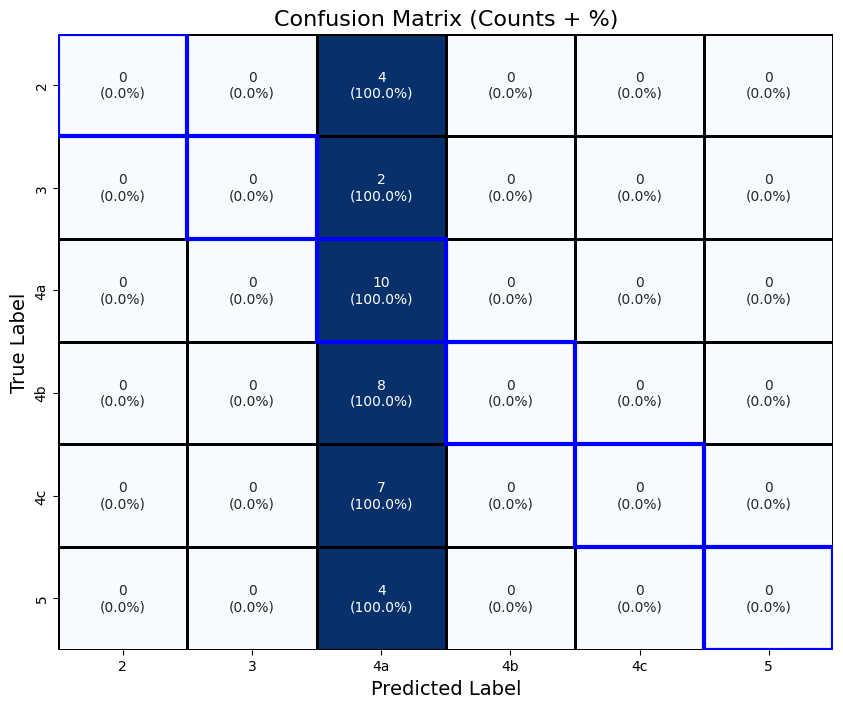

In [10]:
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
classes = ['2','3','4a','4b','4c','5']  # TIRADS labels

# Prepare annotation labels: "count (percent%)"
annot = np.empty_like(cm).astype(str)
n_rows, n_cols = cm.shape
for i in range(n_rows):
    for j in range(n_cols):
        annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm_percent, annot=annot, fmt='', cmap='Blues', xticklabels=classes, yticklabels=classes,
            cbar=False, linewidths=1, linecolor='black')

# Highlight diagonal in darker blue
for i in range(n_rows):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='blue', lw=3))

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (Counts + %)', fontsize=16)
plt.show()


Micro-Averaged ROC AUC: 0.569469387755102


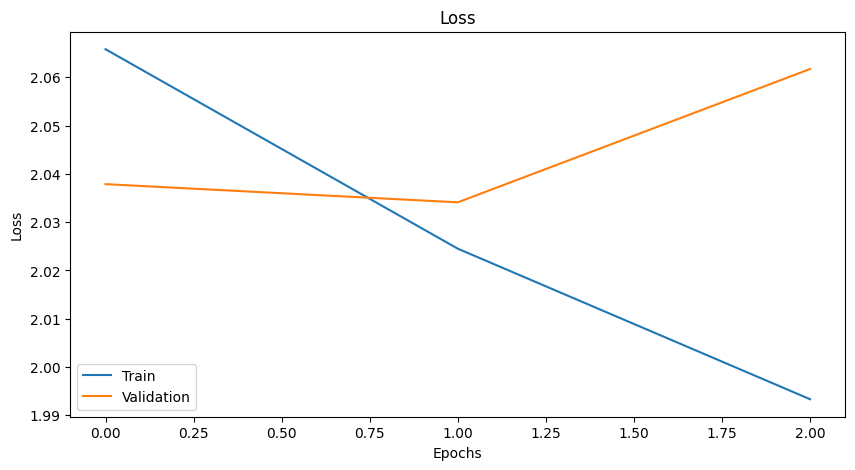

In [11]:

    # Micro-average ROC AUC (OVR)
    try:
        auc_micro = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='micro')
        print("Micro-Averaged ROC AUC:", auc_micro)
    except ValueError as e:
        print("AUC could not be computed:", e)

    # Plot training/validation loss
    plt.figure(figsize=(10,5))
    plt.title('Loss')
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.show()





/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_10']]
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


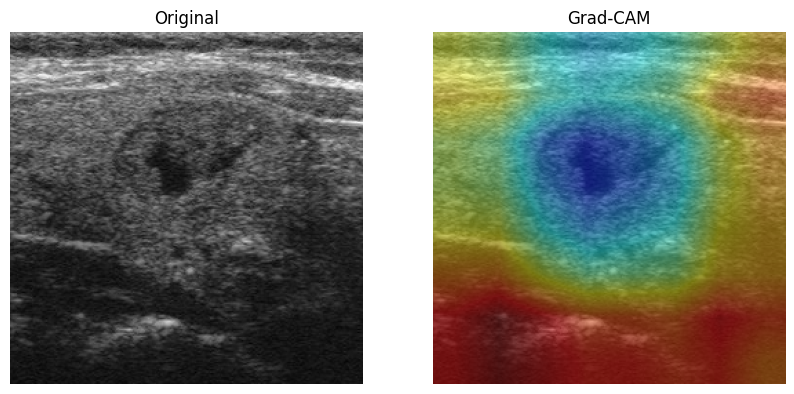

In [12]:

    # ======================
    # Grad-CAM demo on one test image
    # ======================
    if len(x_test) > 0:
        idx = 0  # choose any test index
        img_batch = x_test[idx:idx+1]  # (1,256,256,1)
        heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name='top_conv')

        # Prepare original grayscale in uint8 for overlay
        gray_uint8 = np.uint8(np.clip(x_test[idx, :, :, 0] * 255.0, 0, 255))
        overlay = overlay_gradcam(gray_uint8, heatmap, alpha=0.4)

        # Show side by sidea
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1); plt.title("Original"); plt.imshow(gray_uint8, cmap='gray'); plt.axis('off')
        plt.subplot(1,2,2); plt.title("Grad-CAM"); plt.imshow(overlay[..., ::-1]); plt.axis('off')
        plt.show()

In [13]:
# ======================
# Grad-CAM demo on one test image with category
# ======================
if len(x_test) > 0:
    idx = 0  # choose any test index
    img_batch = x_test[idx:idx+1]  # (1,256,256,1)

    # Get heatmap and prediction
    heatmap, preds = make_gradcam_heatmap(img_batch, model, last_conv_layer_name='top_conv')

    TIRADS_CLASSES = ['2', '3', '4a', '4b', '4c', '5']
    predicted_class = TIRADS_CLASSES[np.argmax(preds)]
    confidence = np.max(preds) * 100

    print(f"Predicted Category: TIRADS {predicted_class} ({confidence:.2f}% confidence)")

    # Prepare original grayscale for overlay
    gray_uint8 = np.uint8(np.clip(x_test[idx, :, :, 0] * 255.0, 0, 255))
    overlay = overlay_gradcam(gray_uint8, heatmap, alpha=0.4)

    # Show side-by-side with category in title
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original (TIRADS {predicted_class})")
    plt.imshow(gray_uint8, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(overlay[..., ::-1])
    plt.axis('off')

    plt.show()


ValueError: too many values to unpack (expected 2)

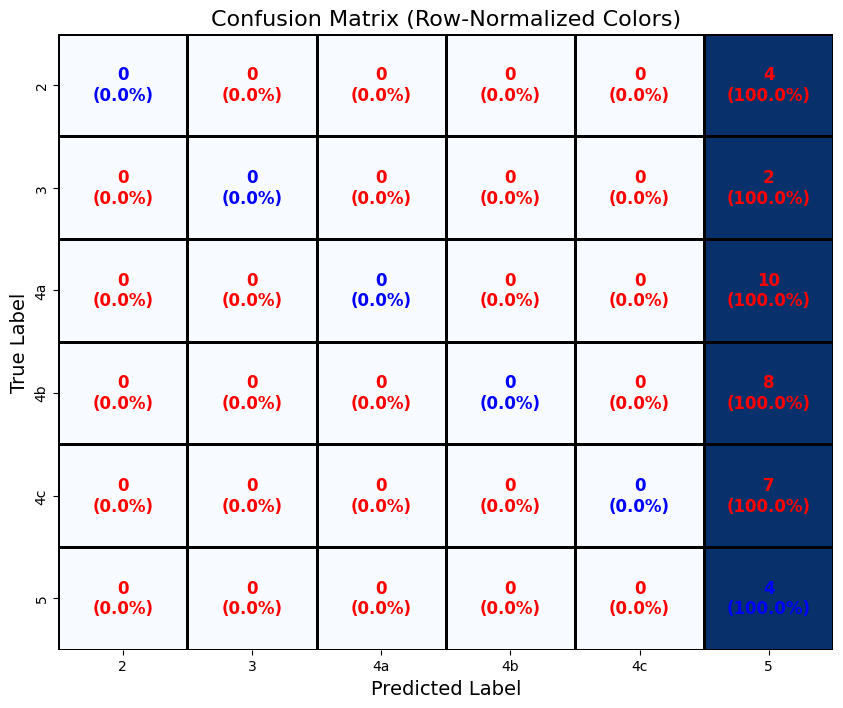

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
classes = ['2','3','4a','4b','4c','5']  # TIRADS labels

# Row-normalize for coloring only
cm_row_norm = cm_percent / cm_percent.max(axis=1)[:, np.newaxis]

# Create figure
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm_row_norm, cmap='Blues', xticklabels=classes, yticklabels=classes,
                 cbar=False, annot=False, linewidths=1, linecolor='black', vmin=0, vmax=1)

# Annotate cells with counts + percentages and color-code text
n_rows, n_cols = cm.shape
for i in range(n_rows):
    for j in range(n_cols):
        text_color = 'blue' if i == j else 'red'
        ax.text(j+0.5, i+0.5, f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)",
                ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (Row-Normalized Colors)', fontsize=16)
plt.show()
